In [1]:
import warnings
import numpy as np
import cv2 as cv
import pandas as pd
import collections
import os

from PIL import Image

from keras.preprocessing import image
from pathlib import Path
from skimage.io import imread

from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import time

import matplotlib.pyplot as plot
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

Using TensorFlow backend.


In [2]:
train_directory = "small_dataset_train/"

# Data Flower
df = pd.read_csv('Flowers.csv',
                 sep = ',',
                 header = 0,
                 index_col = "MediaId",
                 encoding = "utf8").to_numpy()

# Flower Label
fl = df[:, 1].astype('int')

### Renvoi un dictionnaire de listes de toutes les valeurs de pixels de toutes les images du Dataset

In [3]:
def getPixelsFromImage(directory):
    pixels = {}
    
    for subdirectory in os.listdir(directory):
        for file in os.listdir(directory + subdirectory):
            if (file.endswith(".jpg")):
                mediaId = int(os.path.splitext(file)[0])

                image = Image.open(os.path.join(directory + subdirectory, file))
                image = image.resize((100,100))
                
                pixels[mediaId] = list(image.getdata().convert('RGB').convert('P'))
            
    return pixels

In [4]:
fd = getPixelsFromImage(train_directory)

# Sort the dictionaries so it matches the labels
fd = collections.OrderedDict(sorted(fd.items()))

# Only keep the list of values
fd = list(fd.values())[:]

In [5]:
validation_size=0.7 #30% du jeu de données pour le test

testsize= 1-validation_size

X_train, X_test, Y_train, Y_test = train_test_split(fd,
                                                    fl,
                                                    train_size = validation_size,
                                                    test_size = testsize)

### **Evaluation de LogisticRegression, KNeighborsClassifier, Linear SVC, RandomForestClassifier et DecisionTreeClassifier**

Nous créons une table des classifieurs à évaluer

In [6]:
seed = 7
scoring = 'accuracy'
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVC', SVC(gamma='auto')))
models.append(('RFC', RandomForestClassifier()))
models.append(('DTR', DecisionTreeClassifier()))

In [ ]:
seed = 7
results = []
names = []
scoring='accuracy'
for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg) 

Time pour LR   903.8319835662842
LR: 0.487044 (0.028481)
Time pour KNN   138.3841323852539
KNN: 0.515429 (0.025088)
Time pour SVC   1422.0461523532867
SVC: 0.577946 (0.027318)
Time pour RFC   31.376068353652954
RFC: 0.535165 (0.033606)


### Comparaison de résultats de différents classifieurs

[Text(0, 0, 'LR'),
 Text(0, 0, 'KNN'),
 Text(0, 0, 'SVC'),
 Text(0, 0, 'RFC'),
 Text(0, 0, 'DTR')]

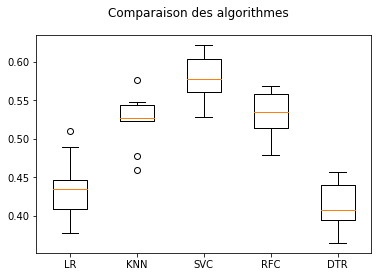

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.suptitle('Comparaison des algorithmes')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

### Tableau pour faciliter la comparaison des classifieurs

In [10]:
# Dictionary of all the classifiers we want to test
classifiers = {
    'KNeighborsClassifier': KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'SVC': SVC()
}

# Dictionary of all their hyper-parameters to tune
parameters = {
    'KNeighborsClassifier': {
        'n_neighbors': [3, 5, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'LogisticRegression': {
        'C': [0.1, 1],
        'solver': ['saga'],
        'multi_class': ['auto']
    },
    'RandomForestClassifier': [
        {'n_estimators': [4, 6, 9]}, 
        {'max_features': ['log2', 'sqrt','auto']}, 
        {'criterion': ['entropy', 'gini']},
        {'max_depth': [2, 3, 5, 10]}, 
        {'min_samples_split': [2, 3, 5]},
        {'min_samples_leaf': [1,5,8]}
    ],
    'DecisionTreeClassifier': [
        {'max_depth': [1,2,3,4,5,6,7,8,9,10]},
        {'criterion': ['gini', 'entropy']},
        {'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10]}
    ],
    'SVC': {
        'C': [0.1, 1],
        'gamma': ['scale'],
        'kernel': ['linear', 'rbf', 'sigmoid'],
        'random_state': [0]
    }
}

### Application de GridSearchCV afin de trouver les meilleurs paramètres pour chaque classifieur


In [11]:
# Class representing a model
class Model:
    def __init__(self, classifier, parameters, score):
        self.classifier = classifier
        self.parameters = parameters
        self.score = score

    def __repr__(self):
        return repr((self.classifier, self.parameters, self.score))

results = []
for classifierName, classifier in classifiers.items():
    gridSearch = GridSearchCV(
        estimator = classifier,
        param_grid = parameters[classifierName],
        scoring = "accuracy",
        cv = 5,
        n_jobs = -1,
        iid = True
    )

    gridSearch.fit(X_train, Y_train)

    result = Model(classifierName, gridSearch.best_params_, gridSearch.best_score_)
    results.append(result)
    print (result.classifier, ": ", result.score, '\n')

results = sorted(results, key = lambda result: result.score, reverse = True)

KNeighborsClassifier :  0.5610859728506787 

LogisticRegression :  0.47716988893459483 

RandomForestClassifier :  0.5853558206499383 

DecisionTreeClassifier :  0.5845331139448786 

SVC :  0.5853558206499383 



### **Recupération du meilleur classifieur avec ses paramètres**

In [12]:
bestModel = results[0]
classifier = eval(bestModel.classifier)()
classifier.set_params(**bestModel.parameters)

classifier.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [13]:
prediction = classifier.predict(X_test)

print("Accuracy: \n", accuracy_score(Y_test, prediction), '\n')
print("Confusion matrix: \n", confusion_matrix(Y_test, prediction), '\n')

Accuracy: 
 0.5771812080536913 

Confusion matrix: 
 [[  0   0  13   0   0]
 [  0   0  57   0   0]
 [  0   0 602   0   0]
 [  0   0 314   0   0]
 [  0   0  57   0   0]] 

